In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import jieba
import jieba.analyse
import re
import stylecloud
from IPython.display import Image

## 数据处理

- 将【时间】字段拆分成日期和时间两列，删除日期在”2020-7-1“之前的数据
- 检查【标题】字段，发现部分豆瓣帖子中标题不含有“杨笠”相关词汇，删除行
- 检查空值，部分帖子为纯图片或视频，内容为空，保留空值不处理

In [2]:
#豆瓣数据
dbyl=pd.read_csv('doubanyl.csv')
dbyl.head()

,title,date,time,group,reply,content,link,grouplink
0,杨笠这种程度的都要挨骂 那脱口秀任何一个男的都应该挨骂,2021-08-19,13:42,豆瓣艾玛花园,0,不用替男的鸣不平 我们骂的是男人 不是喜剧也不是脱口秀,https://www.douban.com/group/topic/243052503/,https://www.douban.com/group/650302/
1,其实，我没有听懂杨笠的讽刺,2021-08-19,13:01,脱口秀大会,5,就是这段，get不到她的讽刺。意思是防止那些男的听到跳脚吗？,https://www.douban.com/group/topic/243048216/,https://www.douban.com/group/700080/
2,室友高中同学骂杨笠是狗… 怎么骂他啊姐妹们,2021-08-19,12:53,不知道如何回复,5,室友没房所以就我来发了，我就是耳朵不好使听岔劈的始作俑者本人😢,https://www.douban.com/group/topic/243047425/,https://www.douban.com/group/687802/
3,男人们为了打倒杨笠已经开始给她扣民粹的帽子了,2021-08-19,12:25,小象八卦,8,如图，这位国师虽然博文严谨，像是一篇宏文，但依然掩盖不了他发这些话的本质。警惕这种很ji贼的...,https://www.douban.com/group/topic/243044371/,https://www.douban.com/group/613560/
4,杨笠的脱口秀是有深度的,2021-08-19,12:00,脱口秀大会,1,罗永浩的上来就拍灯是不必要的，不管是出于什么。杨澜那么做才是尊重杨笠。（杨澜本人也是非常有才...,https://www.douban.com/group/topic/243041839/,https://www.douban.com/group/700080/


In [3]:
#虎扑数据
hpyl=pd.read_csv('hupuyl.csv')
hpyl.head()

,id,title,date,time,group,reply,view,content,link
0,西西里的胖胖啊,杨笠这波什么水平？,2021-08-17,20:26,影视区,1339,1810389,NaN,https://bbs.hupu.com/44816082.html
1,jacoooooooob,张雨霏有点像杨笠觉得吗？,2021-07-29,19:07,步行街主干道,525,633194,脸型啊五官啊啥的,https://bbs.hupu.com/44459647.html
2,鲜衣怒马诗酒趁年华,杨笠再次对男性重拳出击，不成功男性就该去死？（内有完整版视频）,2021-08-17,23:09,娱乐圈,503,950259,NaN,https://bbs.hupu.com/44818438.html
3,网络上我儒雅随和,对于杨笠这种人还是需要抵制,2021-08-18,12:25,影视区,501,714123,之前对杨笠的做法就是不理他，不关注她，让他凉，现在看来还是不行的，对于杨笠这种跳梁小丑，已经...,https://bbs.hupu.com/44824837.html
4,金夏妍是我小姨子,今天综艺杨笠发言,2021-08-17,20:12,综艺圈,477,773529,NaN,https://bbs.hupu.com/44815904.html


## 评论数最多的帖子
分别对豆瓣和虎扑的数据根据评论数进行排序，分别取评论数最高的10条帖子，爬取评论内容并新增至【replycontent】列。

In [4]:
#豆瓣评论最多的10条帖子数据
dbreply=pd.read_csv('doubanreply10.csv')
dbreply

,title,date,time,group,reply,content,link,grouplink,replycontent
0,杨笠这波属实把部分男性整到出现应激反应,2021-08-17,23:06,豆瓣鹅组,628,“我有房有车有存款有妻有子”说完自己仿佛还不太确定 于是立马在自己主页晒了一波财产魅力时刻了嗷🥴,https://www.douban.com/group/topic/242875016/,https://www.douban.com/group/blabla/,<(￣︶￣)/ 这反应倒是更好笑 哈哈哈哈哈哈 晒了车钱表 咋不晒老婆孩子家庭幸福呀 被石头...
1,杨笠杀疯了 笠姐yyds,2021-08-17,19:59,豆瓣艾玛花园,606,@-杨笠- 的微博: #脱口秀大会##杨笠 以后只调侃成功的男... weibo.cn（各位...,https://www.douban.com/group/topic/242850990/,https://www.douban.com/group/650302/,不用！yyds 哈哈哈哈哈哈哈哈杨笠冲啊！！ 👍 不用！笠姐 🐂！！ 哈哈哈哈哈哈哈哈哈哈哈...
2,杨笠：我学会最重要的一个道理就是不要随便调侃男性,2021-08-17,20:43,豆瓣鹅组,473,NaN,https://www.douban.com/group/topic/242856156/,https://www.douban.com/group/blabla/,★rz 笑死了，杨笠还是这么妙语连珠 笠笠yyds 杨笠YYDS 她太强了 哈哈哈哈哈 看了...
3,看今天杨笠脱口秀看哭了，谁懂,2021-08-17,20:03,豆瓣鹅组,349,虽然她前面说有人老让她讲男女话题，老让她勇敢，感觉要逼死她。但是她还是说了😭而且说的非常精彩...,https://www.douban.com/group/topic/242851370/,https://www.douban.com/group/blabla/,就在这晒。晒。晒足一百八十帖 你啥时候回来的？ 没反应过来 今天都更新了？ 对的，快去看～ ...
4,杨笠yyds,2021-08-17,20:06,自由吃瓜基地-更爱...,273,NaN,https://www.douban.com/group/topic/242851723/,https://www.douban.com/group/gua/,哈哈哈哈哈哈哈哈哈 反讽一套一套的 哈哈哈哈哈哈哈哈哈哈哈哈 哈哈哈哈哈哈哈哈 牛批 哈哈哈...
5,杨笠又炸场了,2021-08-17,20:34,豆瓣鹅组,263,NaN,https://www.douban.com/group/topic/242855085/,https://www.douban.com/group/blabla/,ヾ(￣▽￣)Bye~Bye~ 哈哈哈哈 笠姐yyds 她的每一场演出都让我比上一场更爱她 好...
6,问:男的说杨笠已经掌握流量密码，该怎么怼?,2021-08-17,23:54,豆瓣鹅组,252,“微博属实给她整明白了”“她掌握了男女对立的流量密码”“故意煽动男女对立”这种故作玄虚的样子...,https://www.douban.com/group/topic/242880572/,https://www.douban.com/group/blabla/,😠 女性掌握流量密码还是太迟了，这一点远不如男性 这流量你们男的吃了几千年 就不兴我们女的也...
7,杨笠的话妙在真的有人听不懂在骂自己,2021-08-17,22:20,豆瓣鹅组,249,杨笠鲨疯了。,https://www.douban.com/group/topic/242868961/,https://www.douban.com/group/blabla/,( *′д)/o(_ _)ozzZZ… 杨笠，一个不止可以让你识别出优质男性，还可以让你远离...
8,i脱口秀在吗 杨笠又开始🐮了,2021-08-17,20:05,豆瓣秀组,236,很难不瑞思拜微博偷的图👇🏻今晚又要气死谁了 笑嘻了,https://www.douban.com/group/topic/242851640/,https://www.douban.com/group/660535/,在哪看到的呀？ 杨笠真的瑞思拜她 woc 今晚更新吗 我都忘了 最新一期还没看 笠姐我来了 ...
9,因为杨笠和男朋友分手了,2021-08-18,16:41,生活组,236,他今天中午给我买的奶茶还没喝完我就跟他提分手了，他也同意了大概就是，我看到杨笠昨天的脱口秀然...,https://www.douban.com/group/topic/242947626/,https://www.douban.com/group/586674/,两边都不帮的就不叫支持女权啊 我也这么回复的 我说这不就是理中客吗 他回我他想骂我了 不想摻...


In [5]:
#虎扑评论最多的10条帖子数据
hpreply=pd.read_csv('hupureply10.csv')
hpreply

,id,title,date,time,group,reply,view,content,link,replycontent
0,西西里的胖胖啊,杨笠这波什么水平？,2021-08-17,20:26,影视区,1339,1810389,NaN,https://bbs.hupu.com/44816082.html,这波啊，这波是搬起石头砸自己的脚啊 她的人设就是这样，没啥好喷的，反对声越大人家流量越高。只...
1,jacoooooooob,张雨霏有点像杨笠觉得吗？,2021-07-29,19:07,步行街主干道,525,633194,脸型啊五官啊啥的,https://bbs.hupu.com/44459647.html,别恶心我… 不许你这样说我老婆 别侮辱奥运冠军行吗？ 确实像，但你肯定会被喷。 就说长得像...
2,鲜衣怒马诗酒趁年华,杨笠再次对男性重拳出击，不成功男性就该去死？（内有完整版视频）,2021-08-17,23:09,娱乐圈,503,950259,NaN,https://bbs.hupu.com/44818438.html,买我的代言你就是成功 像女人一样？ 哎你管她干嘛啊 多看立姐的脱口秀，多支持立姐的人...
3,网络上我儒雅随和,对于杨笠这种人还是需要抵制,2021-08-18,12:25,影视区,501,714123,之前对杨笠的做法就是不理他，不关注她，让他凉，现在看来还是不行的，对于杨笠这种跳梁小丑，已经...,https://bbs.hupu.com/44824837.html,看见杨笠直接滑动进度条，直接跳过去看rock了！ 动不动抵制这个抵制那个，和微博豆瓣被喷的那...
4,金夏妍是我小姨子,今天综艺杨笠发言,2021-08-17,20:12,综艺圈,477,773529,NaN,https://bbs.hupu.com/44815904.html,别的不说，都美竹和阿里的那位女性还是值得敬佩的，如果你认为揭示男人错误=女拳，那我觉得你=...
5,虎扑JR2122993024,杨笠代言资生堂,2021-07-26,15:30,步行街主干道,474,761207,rt，望转周知,https://bbs.hupu.com/44400949.html,第二张图真的太丑了 她那么普通，却那么自信 已经换成舒肤佳了 这女的是真的丑，她让我相信了女...
6,sadsasdj,脱口秀大会第四季，杨笠继续说男女话题，你怎么看,2021-08-17,20:39,娱乐圈,426,557773,NaN,https://bbs.hupu.com/44816290.html,姐姐太勇了 好飒(yue) 微博上的那一堆拳师还以为她又在调侃男性都在拍手叫好 晦气 哈哈...
7,煤气罐蒂亚戈,杨笠的话被小鹏汽车用来营销，绝不会买小鹏,2021-08-19,13:45,步行街主干道,369,729892,小鹏的官微今天发了这张图，用杨笠的话来做营销，真特么恶心，low。本来觉得新能源车里小鹏还行...,https://bbs.hupu.com/44840305.html,举报他 也许杨立给别人好处呢 我怀疑是友商的奸细🐶 营销鬼才 估计是个娘炮或者干脆就是女...
8,alexfrost,杨笠今晚8点开始为资生堂带货直播，这能忍？,2021-07-27,19:16,步行街主干道,353,705085,资生堂有很多男士men系列专用产品！旗下品牌包括安耐晒、CPB、洗颜专科，居然找这人来直播，...,https://bbs.hupu.com/44422619.html,十几个人看，你激动啥 那 骂起来没力量啊…… 不鸟她，晦气 十几个人看，你激动啥 给我截个图...
9,练习练习666,各位jrs杨笠这波相亲什么水平？,2021-07-29,00:23,娱乐圈,248,519772,对每个男嘉宾都不满意，嫌弃年纪大的嘉宾，给她年纪小的嘉宾又说人家没用简直又当又立界的标杆当初...,https://bbs.hupu.com/44446339.html,别看 只此一次，再倒垃圾就举报拉黑 晦气 他爹:？？？ 虽然我就那么多点。。。。 能不...


## 豆瓣和虎扑讨论的小组
查看用户分别在豆瓣和虎扑的哪些小组里讨论

In [6]:
#查看分别有多少个小组
print('豆瓣相关小组总数:%d'%(len(dbyl['group'].unique())))
print('虎扑相关小组总数:%d'%(len(hpyl['group'].unique())))

豆瓣相关小组总数:77
虎扑相关小组总数:6


In [8]:
print(dbyl['group'].unique())

['豆瓣艾玛花园' '脱口秀大会' '不知道如何回复' '小象八卦' '女权来啦' '豆瓣鹅组' '自由吃瓜基地-更爱...' '四合院办公室'
 '我们都是吐槽控' '「人生问题」研究社' '万象生活' '热概念冷思考' '这河里吗' '生活组' '她说' '深夜倒垃圾' '青青草原'
 'cmsx' 'Cherry & Strawberry' '寿司生活组' '豆瓣劝分小组' '各界翻红反转研究' '林阵磨枪｜给冷cp...'
 '豆瓣吃瓜人才组' '豆瓣发财组' '豆瓣戏影专业点评' '今天我没有生气' '豆瓣秀组' '青春有你|植树组' '豆瓣花组'
 '青春有你4 风华绝代组' 'KPL烟花电子厂' '笑死我了这弹幕' '豆瓣韩式泡菜小组' '豆瓣流浪瓜农' '史上最随便小组' '自由小组'
 '乘风破浪的姐姐的...' '新世代音乐功夫季S...' '未命名' '秀芬拯救中心' '咕噜肉秃噜皮呼噜毛' '硬糖实验室' '豆瓣拉踩小组'
 '视觉趋势研究小组' '去政治化娱乐中心' '我总觉得自己就是...' '豆瓣橘组|青春有你' '鹅们栖息地' '这件衣服好看吗！！！'
 '咯噔学研究' '塞纳河防安利小组' '豆瓣戏精小组' 'TF三代守护和平协会' '旧日议事厅' '精神乌克兰女孩' '时代峰峻今日形势严峻'
 '糊坛避难所' '豆瓣温泉镇（夏日...' '海花岛| 创造营202...' '要滚你先滚反正我不滚' 'Girls Planet 999...'
 '影视吐槽|胡作非为组' '豆瓣爽组' '心动的信号' '宇光同丞' '少年说唱企划-Z时代' '硬糖少女加工厂' '不要姜葱蒜'
 'shark废话海' '豆瓣吃瓜组' '豆瓣吃瓜人才组复...' '四合院' '养只心心' '「人生问题」诊所' '国产影视组' 'INTJ女']


In [9]:
db_group=dbyl.groupby('group').agg({'title':'count','reply':'sum'}) 
db_group.sort_values('title', ascending=False)

,title,reply
group,,
豆瓣鹅组,57,5226
自由吃瓜基地-更爱...,34,1439
豆瓣艾玛花园,32,2370
脱口秀大会,23,626
青青草原,12,266
...,...,...
养只心心,1,14
糊坛避难所,1,20
今天我没有生气,1,2


In [10]:
hp_group=hpyl.groupby('group').agg({'title':'count','reply':'sum'}) 
hp_group.sort_values('title', ascending=False)

,title,reply
group,,
娱乐圈,37,2350
步行街主干道,28,2437
影视区,19,2575
综艺圈,5,601
湿乎乎的话题,3,342
车友交流,2,53


## 豆瓣和虎扑评论词云图
对豆瓣和虎扑评论数最多的10条帖子下的评论进行分词，制作词云图

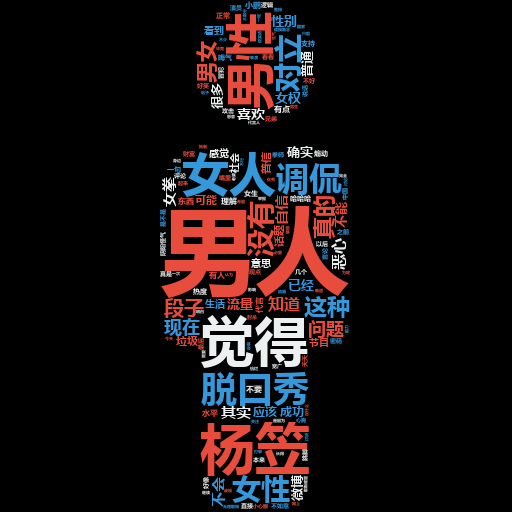

In [11]:
stylecloud.gen_stylecloud(file_path='hpsegwords.csv',
                          icon_name='fas fa-male',
                          colors=['#ecf0f1', '#3498db', '#e74c3c'],
                          font_path='/Users/julia/Library/Fonts/msyhbd.ttf',
                          background_color='black',
                          gradient='horizontal',
                          output_name='hupu.png'
                         )
Image(filename='hupu.png')

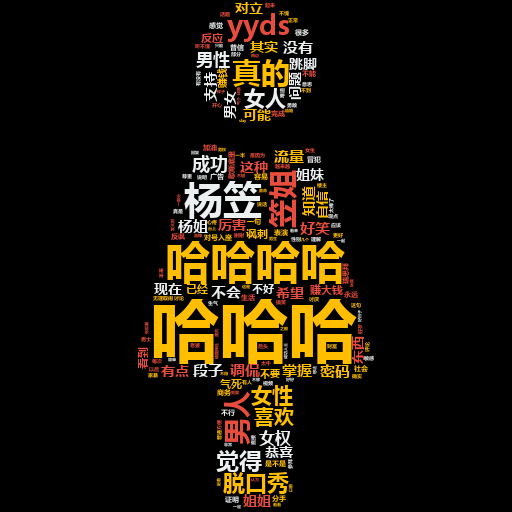

In [12]:
stylecloud.gen_stylecloud(file_path='dbsegwords.csv',
                          icon_name='fas fa-female',
                          colors=['#ecf0f1', '#ffbf00', '#e74c3c'],
                          font_path='/Users/julia/Library/Fonts/msyhbd.ttf',
                          background_color='black',
                          gradient='horizontal',
                          output_name='douban.png'
                         )

Image(filename='douban.png')

## 豆瓣虎扑热评关键词分布
以堆叠条状图的形式，展示词频TOP30的热评词语分别在豆瓣和虎扑的分布情况

In [13]:
# 关键词数量堆叠柱状图
from pyecharts.charts import Bar
from pyecharts import options as opts
from pyecharts.commons.utils import JsCode

result3=pd.read_csv('dbhpreply30.csv')

bar = (Bar(init_opts=opts.InitOpts(theme='dark'))
       .add_xaxis(result3['关键词'].tolist())
       .add_yaxis('虎扑', result3['虎扑'].tolist(), stack='stack1', category_gap='40%', yaxis_index=1)
       .add_yaxis('豆瓣', result3['豆瓣'].tolist(), stack='stack1', category_gap='40%', yaxis_index=1)
       .extend_axis(yaxis=opts.AxisOpts(name='词频', type_='value', min_=0, max_=600, position='right',
                                        axislabel_opts=opts.LabelOpts(formatter='{value} 次')))
       .extend_axis(yaxis=opts.AxisOpts(type_='value', position='left',
                                        axislabel_opts=opts.LabelOpts(formatter='{value} 小时'),
                                        splitline_opts=opts.SplitLineOpts(is_show=True, linestyle_opts=opts.
                                                                          LineStyleOpts(opacity=1))))
       .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
       .set_global_opts(title_opts=opts.TitleOpts(title='杨笠相关帖子评论区关键词', subtitle='豆瓣虎扑讨论热度最高的10条帖子'),
                        xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=25, font_size=11)),
                        datazoom_opts=opts.DataZoomOpts(), tooltip_opts=opts.TooltipOpts(trigger='axis',
                        axis_pointer_type='cross'))
       )

bar.render("barhp.html")
bar.render_notebook()